In [16]:
import glob
import skimage
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel, roberts
from skimage import exposure
from skimage.draw import circle_perimeter
from skimage.feature import peak_local_max, canny
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.util import crop
from skimage.color import rgb2gray

In [319]:
def get_image_data(im_dir):
    '''
    INPUT: name of directory containing images (str), with sub-directories separated by '\\'
    OUTPUT: pandas dataframe of the gray-scale image N x 5 matrix with N = number of images and
            columns = [Date, Environ, Choloramphenicol,-Log10(Dilution),gray-scale pixel values]
    MODULES: glob, skimage, pandas
    '''
    
    # Imports
    import glob
    from skimage.io import imread
    from skimage.color import rgb2gray
    import pandas as pd
    
    im_list = list( glob.glob(im_dir + "/**/*.jpg",recursive=True))
    images = [rgb2gray(skimage.io.imread(im_name)) for im_name in im_list]
    
    # Load images and store in list 
    im_list = list(im.split('\\') + [images[idx]] for idx, im in enumerate(im_list))
    images = pd.DataFrame(im_list,columns = ['drop','Date','treatment','Image']).drop('drop',axis= 1)
    
    # remove .JPG tag, make new columns for treatment
    treatment = images.pop('treatment')
    conditions_df = pd.concat([treatment] * 3, axis = 1)
    conditions_df.columns = ['CHL','Environ','-Log(Dilution)']
    for idx, condition in enumerate(treatment):
        agar, environ, dilution = tuple(condition.split('_'))
        if agar == 'MEA':
            conditions_df.loc[idx,'CHL'] = 'Yes'
        else:
            conditions_df.loc[idx,'CHL'] = 'No'
        conditions_df.loc[idx,'Environ'] = environ
        conditions_df.loc[idx,'-Log(Dilution)'] =  dilution.replace('.JPG','')

    # Now create output matrix
    data = pd.concat([images,conditions_df], axis = 1)
    data_arranged = data[['Date','Environ','CHL','-Log(Dilution)','Image']]
    
    return data_arranged

In [375]:
images = load_images('data')


In [376]:
example = images.loc[(images['Environ'] == 'O2') & (images['Date'] == '111619') & (images['CHL'] == 'No') & (images['-Log(Dilution)'] == '3')]['Image'].item()

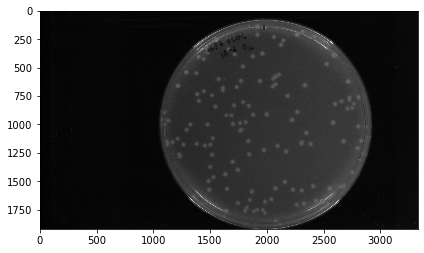

In [493]:
skimage.io.imshow(example)

In [491]:
def plate_edge_detector(image,sigma=5,low_threshold=7,high_threshold=40):
    '''
    INPUT: - Plate Image
           - optional: sigma, low threshold, high_theshold (see skimage)
    OUPUT: Canny Filter for edge of plate
    modules: skimage
    '''
    from skimage.feature import canny
    from skimage.util import img_as_ubyte
    image = img_as_ubyte(image)
    return canny(image,sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

C:\Users\Theo Yang\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
C:\Users\Theo Yang\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


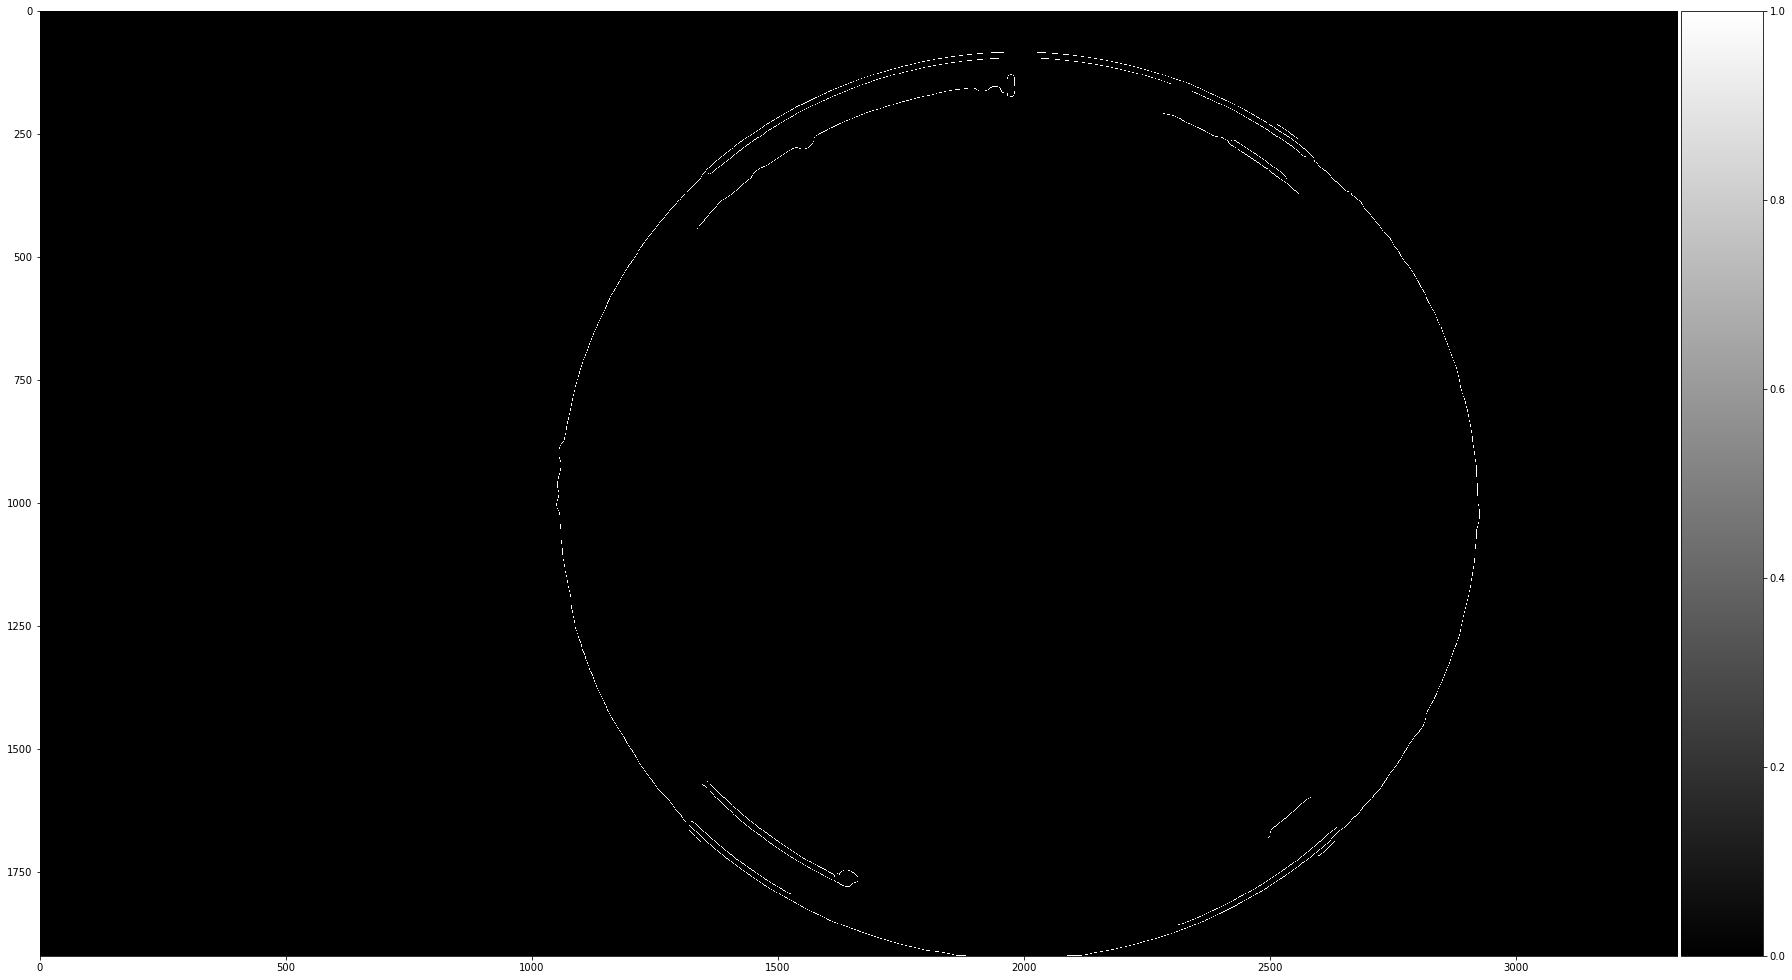

In [494]:
edge = plate_edge_detector(example)
plt.figure(figsize = (25,50))
skimage.io.imshow(edge,cmap=plt.cm.gray)

In [505]:
def define_roi(image,edge):
    '''
    INPUT: - Plate Image 
           - edge detected by plate_edge_detector
    OUPUT: region of interest (roi) in which analysis will be done
    modules: skimage
    '''
    from skimage.transform import hough_circle, hough_circle_peaks
    from skimage.draw import circle_perimeter
    from skimage.util import img_as_ubyte
    from skimage.color import gray2rgb
    image = img_as_ubyte(image)
    r = 1880/2
    hough_radii = np.arange(r-5,r+5, 2)
    hough_res = hough_circle(edge,hough_radii)
    accums, cx, cy, radius = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 40))
    image = gray2rgb(image)
    print(accums, cx, cy, radius)
    circy, circx = circle_perimeter(int(cy), int(cx), int(radius),shape=image.shape)
    image[circy, circx] = (220, 20, 90)

    ax.imshow(image, cmap=plt.cm.gray)
    return hough_res

C:\Users\Theo Yang\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


[0.16101056] [1987] [1019] [937.]


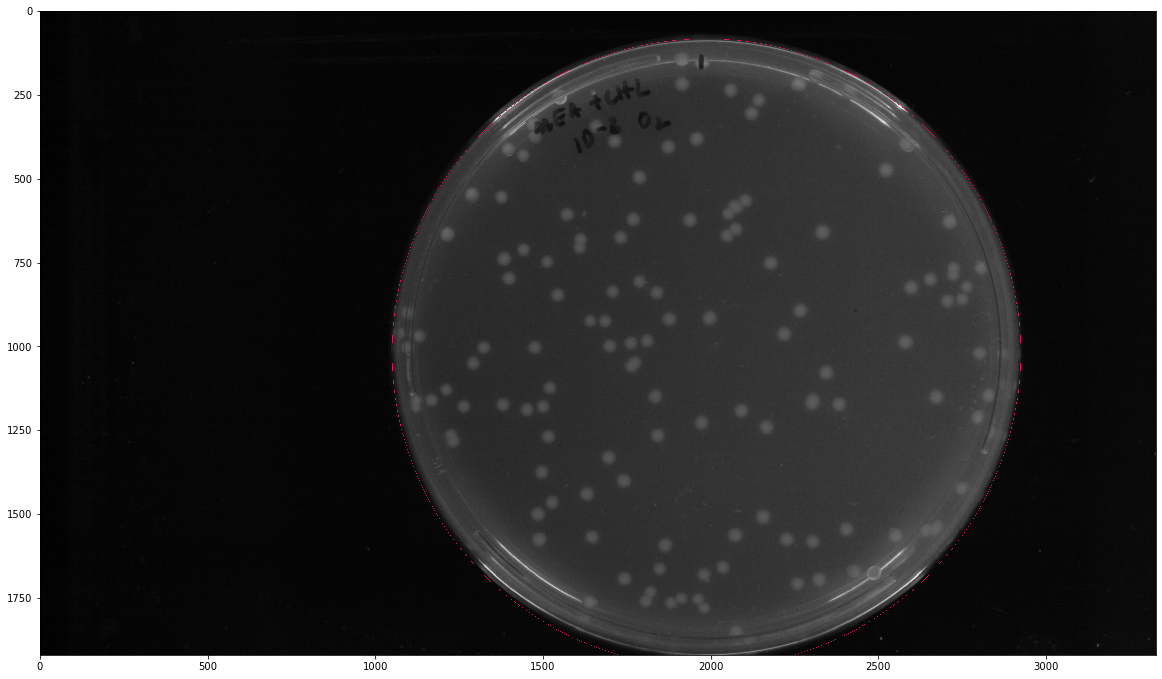

In [506]:
y = define_roi(example,edge)